In [2]:
import pandas as pd
import spacy
import steamreviews
import json
import csv
import os
import glob
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt

## Reviews download
https://pypi.org/project/steamreviews/

In [3]:
dir_name = "data"
reviews_jsons = glob.glob(f"{dir_name}/*")
reviews_jsons

['data\\review_1150690.json',
 'data\\review_1172620.json',
 'data\\review_1341290.json',
 'data\\review_1515210.json',
 'data\\review_210970.json',
 'data\\review_219150.json',
 'data\\review_219890.json',
 'data\\review_250320.json',
 'data\\review_257510.json',
 'data\\review_262060.json',
 'data\\review_289070.json',
 'data\\review_294100.json',
 'data\\review_304430.json',
 'data\\review_394360.json',
 'data\\review_400.json',
 'data\\review_427520.json',
 'data\\review_460950.json',
 'data\\review_550.json',
 'data\\review_620.json',
 'data\\review_632470.json',
 'data\\review_646570.json',
 'data\\review_736260.json',
 'data\\review_860510.json']

In [4]:
title_dict = {"219150": "Hotline Miami",
              "1172620" : "Sea of Thieves",
              "460950" : "Katana ZERO",
              "262060" : "Darkest Dungeon",
              "250320" : "The Wolf Among Us",
              "210970" : "The Witness",
              "620" : "Portal 2",
              "736260" : "Baba Is You",
              "219890" : "Antichamber",
              "289070" : "Sid Meier's Civilization VI",
              "427520" : "Factorio",
              "257510" : "The Talos Principle",
             "304430" : "INSIDE",
             "400" : "Portal",
             "394360" : "Hearts of Iron IV",
             "632470" : "Disco Elysium",
             "294100" : "RimWorld",
              "646570" : "Slay the Spire",
              "1150690" : "Omori",
              "1341290" : "We Were Here Forever",
              "1515210" : "The Past Within",
              "860510" : "Little Nightmares II",
              "550" : "Left 4 Dead 2"}

In [5]:
genre_dict = {"219150": "A",
              "1172620" : "A",
              "460950" : "A",
              "262060" : "R",
              "250320" : "R",
              "210970" : "P",
              "620" : "P",
              "736260" : "P",
              "219890" : "P",
              "289070" : "S",
              "427520" : "S",
              "257510" : "P",
              "304430" : "P",
             "400" : "P",
             "394360" : "S",
             "632470" : "R",
             "294100" : "S",
             "646570" : "R",
             "1150690" : "R",
             "1341290" : "P",
             "1515210" : "P",
             "860510" : "P",
             "550" : "A"}

In [6]:
data_list = []
for i in reviews_jsons:
    with open(i, encoding = "utf-8") as json_file:
        json_data = json.load(json_file)
        reviews = json_data['reviews']
        file_name = json_file.name.split('.')[0].split('_')[1]
        for key in reviews.keys():
            data_list.append([title_dict.get(file_name),genre_dict.get(file_name),reviews[key]['author']['steamid'], reviews[key]['votes_up'], 
                          reviews[key]['review'], reviews[key]['weighted_vote_score'],  
                          reviews[key]['author']['num_games_owned'], reviews[key]['author']['playtime_at_review'],
                          reviews[key]['author']['num_reviews'], 
                          reviews[key]["timestamp_created"] ])
df = pd.DataFrame(data_list, columns = ["title", "genre","steamid", "votes_up", "review", "weighted_vote_score", 
                                        "num_games_owned", "playtime_at_review", "num_reviews", "timestamp_created"])

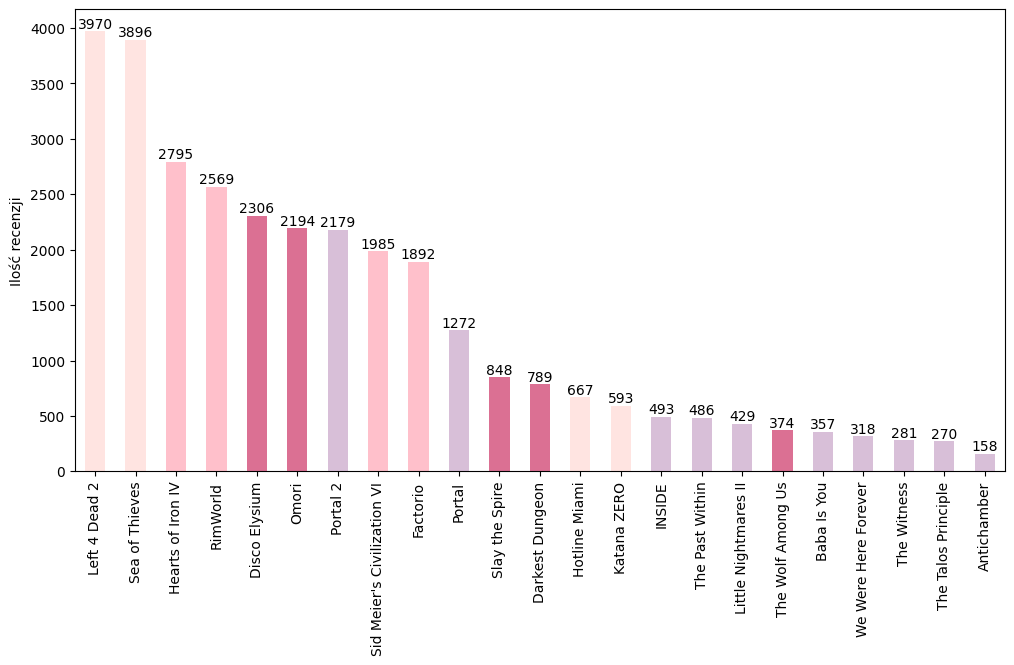

In [7]:
value_counts_title = df["title"].value_counts()
genre_colors = {"A": "mistyrose", "R": "palevioletred", "P": "thistle", "S": "pink"}
df['color'] = df['genre'].map(genre_colors)
colors = [df.loc[df['title'] == title]['color'].iloc[0] for title in value_counts_title.index]

plt.figure(figsize=(12, 6))
x = value_counts_title.plot(kind = "bar", color = colors)
plt.ylabel("Ilość recenzji")
plt.xticks(rotation = 90)
for i, count in enumerate(value_counts_title):
    x.text(i, count, count, va = "bottom", ha = "center")

plt.show()

In [8]:
df.sample(frac=0.3).head()

,title,genre,steamid,votes_up,review,weighted_vote_score,num_games_owned,playtime_at_review,num_reviews,timestamp_created,color
13701,RimWorld,S,76561198122551913,1,"""This game is going to be banned in australia ...",0.509803950786590576,110,24523,2,1666528061,pink
879,Omori,R,76561198841779364,2,The single greatest game I have ever played. I...,0.523809552192687988,0,1851,4,1682309028,palevioletred
4632,Sea of Thieves,A,76561198064108447,1,The server are just the right amount of dead f...,0.523809552192687988,151,8380,31,1667460595,mistyrose
19766,Factorio,S,76561198362915625,1,Crack!,0.523809552192687988,139,12506,12,1666729857,pink
14958,Hearts of Iron IV,S,76561199099834085,2,i lost 6h of my life but atleast i got motoris...,0.52710801362991333,0,367,1,1682693560,pink


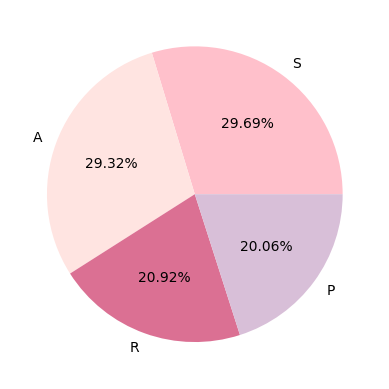

In [9]:
value_counts_genre = df["genre"].value_counts()
colors = ["pink", "mistyrose", "palevioletred", "thistle"]
x = plt.pie(value_counts_genre, labels = value_counts_genre.index, colors=colors, autopct='%1.2f%%')
plt.show()

## Preprocessing

1. Braki danych
2. Sprawdzenie duplikatów
3. Usunięcie recenzjii osób, które grały mniej niż godzinę w momencie publikacji recenzji
4. Usunięcie recenzjii krótszych niż 4 słowa
5. Usunięcie znaków ASCII

In [10]:
df.isna().sum()

title                  0
genre                  0
steamid                0
votes_up               0
review                 0
weighted_vote_score    0
num_games_owned        0
playtime_at_review     0
num_reviews            0
timestamp_created      0
color                  0
dtype: int64

In [11]:
df.duplicated(subset='review').sum()

2523

#### Czas gry mniejszy od godziny

In [12]:
df["playtime_at_review"] = df["playtime_at_review"] / 60

In [15]:
df[df["playtime_at_review"] <1]["title"].value_counts()

Left 4 Dead 2                  85
Portal                         51
Sea of Thieves                 47
Hearts of Iron IV              40
Portal 2                       39
Sid Meier's Civilization VI    37
Disco Elysium                  37
Omori                          23
Hotline Miami                  19
Factorio                       17
RimWorld                       14
Little Nightmares II           14
Baba Is You                    13
Katana ZERO                    12
INSIDE                         11
Darkest Dungeon                 8
The Witness                     5
Antichamber                     4
The Talos Principle             3
Slay the Spire                  3
The Past Within                 2
The Wolf Among Us               1
We Were Here Forever            1
Name: title, dtype: int64